In [37]:
import torch
import torch.nn.functional as F

# Functions from the CC-paper
def lambda_to_eta(lam):
    # lam: (n, K+1)
    # Compute eta_k = log(lam_k / lam_{K})
    # lam, _ = torch.sort(lam,descending=True)

    lam_K = lam[:, -1].unsqueeze(1)        # (n, 1)
    eta = torch.log(lam) - torch.log(lam_K)           # (n, K+1)
    return eta[:, :-1] 

def eta_to_lambda(eta):
    # eta: shape (n, K-1)
    # Append zero column then softmax
    n = eta.shape[0]
    aug_eta = torch.cat([eta, torch.zeros(n, 1, device=eta.device, dtype=eta.dtype)], dim=1)
    return F.softmax(aug_eta, dim=1)


def cc_log_normalizer(eta):
    # eta: (n, K-1)
    n, K = eta.shape
    
    aug_eta = torch.cat([eta, torch.zeros(n, 1, dtype=eta.dtype, device=eta.device)], dim=1)
    # aug_eta = torch.clamp(aug_eta, min=1e-6)
    lse = torch.logsumexp(aug_eta, dim=1)
    res = -cc_log_norm_const(eta) + lse
    return res

def cc_log_norm_const(eta):
    
    # eta: (n, K)
    n, K = eta.shape

    eta_np = eta.detach()                          # stop gradient equivalent
    sds = torch.std(eta_np, dim=1)
    scaling_factors = sds / 1.0

    aug_eta = torch.cat([eta, torch.zeros(n, 1, device=eta.device, dtype=eta.dtype)], dim=1)
    lam = F.softmax(aug_eta, dim=1)

    scaling_factors = torch.clamp(scaling_factors, min=1e-04)
    aug_eta = aug_eta / scaling_factors.unsqueeze(1)

    rows = aug_eta.unsqueeze(2)                    # shape (n, K+1, 1)
    cols = aug_eta.unsqueeze(1)                       # shape (n, 1, K+1)
    eta_diffs = rows - cols

    eta_diffs = eta_diffs + torch.eye(K+1, device=eta.device, dtype=eta.dtype)

    dens = torch.prod(eta_diffs, dim=1)
    # dens = torch.clamp(dens, min=1e-4)

    # inner_part = ((-1)**K) * (lam / dens).sum(dim=1)
    # inner_part = torch.clamp(inner_part, min=1e-4)
    # res = -torch.log((inner_part)) \
    #       + K * torch.log(scaling_factors)
    sign = (-1)**K
    sum_K = torch.sum(lam / dens, dim=1)

    #How chat suggest getting rid of nan values
    val = sign * sum_K
    val = torch.clamp(val, min=1e-12)
    res = -torch.log(val) + K * torch.log(scaling_factors + 1e-12)

    # Nan values if any negative values in the log
    # res = -torch.log(sign * sum_K) + \
    #       K * torch.log(scaling_factors)

    return res


def cc_mean(eta):
    # eta: Tensor of shape (batch, K-1)
    eta_var = eta.clone().detach().requires_grad_(True)
    C = cc_log_normalizer(eta_var) 
    
    res = torch.autograd.grad(
        C.sum(), eta_var, create_graph=False, retain_graph=False
    )[0]
    # Autodiff: dC/deta
    # If C is (batch,), we need grad_outputs to match
    # grad = torch.autograd.grad(
    #     outputs=C,
    #     inputs=eta,
    #     grad_outputs=torch.ones_like(C),
    #     create_graph=False,
    #     retain_graph=False,
    #     only_inputs=True
    # )[0]

    remainder = 1. - torch.sum(res, dim=1)
    res = torch.cat([res, remainder.unsqueeze(1)], dim=1)

    # Mask invalid rows
    # bad_means = (res <= 0).any(dim=1)
    # res[bad_means] = float('nan')
    res = torch.clamp(res, min=1e-12)
         # cc_log_normalizer must return a scalar per row


    return res

In [2]:
import torch.nn as nn
import torch.nn.functional as F

EPS = 1e-8

class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim,bottle):
        super().__init__()
        self.bottle=bottle
        layers = []
        last = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        self.net = nn.Sequential(*layers)
        # output positive concentration parameters \hat{alpha} for each latent dim
        self.alpha_layer = nn.Linear(last, latent_dim)
        self.lambda_layer = nn.Linear(last, latent_dim)
        # with torch.no_grad():
        #     self.lambda_layer.bias[:] = 0.0
        #     self.lambda_layer.bias[0] = 5.0
        self.mu_layer = nn.Linear(last, latent_dim)
        self.logvar_layer = nn.Linear(last, latent_dim)

    def forward(self, x):
        h = self.net(x)
        # softplus to ensure positive alpha_hat; add small bias to avoid zero
        if self.bottle=="dir":
          alpha_hat = F.softplus(self.alpha_layer(h))
          alpha_hat = alpha_hat.clamp(min=1e-3, max=50)
          return alpha_hat
        elif self.bottle=="gaus":
          mu = self.mu_layer(h)
          logvar = self.logvar_layer(h)
          return mu, logvar
        elif self.bottle=="cc":
            lambda_hat = F.softplus(self.lambda_layer(h))
            lambda_hat = lambda_hat.clamp(min=1e-5)
            return lambda_hat


class BernoulliDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        last = latent_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        layers.append(nn.Linear(last, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        logits = self.net(z)
        # return logits (use BCEWithLogitsLoss)
        return logits

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
EPS = 1e-8


class GaussianVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim,"gaus")
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decoder(z)
        return logits, mu, logvar, z

def gaussian_vae_elbo_loss(model, x, reduction='mean'):
    """
    Negative ELBO for Gaussian VAE with Bernoulli likelihood.
    """
    logits, mu, logvar, z = model(x)

    # Reconstruction loss
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()

    # KL divergence between q(z|x) and N(0, I)
    kl_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    if reduction == 'mean':
        kl = kl_per_sample.mean()
    else:
        kl = kl_per_sample.sum()

    loss = recon_loss + kl
    return loss, recon_loss, kl


In [4]:
class DirVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim,
                 prior_alpha=None, beta=1.0):
        """
        input_dim: flattened input size (e.g. 28*28)
        enc_hidden_dims: list of encoder hidden sizes
        dec_hidden_dims: list of decoder hidden sizes
        latent_dim: K
        prior_alpha: vector or scalar for Dirichlet prior concentration alpha (if scalar, replicate)
        beta: rate parameter for Gammas (paper uses beta=1)
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim,"dir")
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)
        if prior_alpha is None:
            # default weak symmetric prior; user can override
            prior_alpha = torch.ones(latent_dim) * 0.98
        elif torch.is_tensor(prior_alpha):
            if prior_alpha.numel() == 1:
                prior_alpha = prior_alpha.repeat(latent_dim)
        else:
            # numeric scalar
            prior_alpha = torch.tensor(float(prior_alpha)).repeat(latent_dim)
        self.register_buffer('prior_alpha', prior_alpha.float())
        self.beta = float(beta)

    def inverse_gamma_cdf_approx(self, u, alpha):
        """
        Approximate inverse CDF for X ~ Gamma(alpha, beta) using:
        F^{-1}(u; alpha, beta) ≈ beta^{-1} * (u * alpha * Gamma(alpha))^{1/alpha}
        u: uniform samples in (0,1), shape (batch, K)
        alpha: shape (batch, K) or (K,)
        returns: approx gamma samples shape (batch, K)
        """
        # alpha * Gamma(alpha) = alpha * exp(lgamma(alpha))
        # note: torch.lgamma for log Gamma
        # shapes broadcast
        log_gamma = torch.lgamma(alpha)
        a_gamma = alpha * torch.exp(log_gamma)  # shape (batch, K)
        # clamp u to (eps, 1)
        u = u.clamp(min=EPS, max=1.0 - 1e-12)
        base = u * a_gamma
        # to avoid negative/zero values due to numerical issues, clamp base
        base = base.clamp(min=EPS)
        # power 1/alpha
        samples = (base) ** (1.0 / alpha)
        # divide by beta (rate)
        samples = samples / (self.beta + 0.0)
        return samples
    
    def sample_dirichlet_from_alpha(self, alpha_hat):
        """
        Given alpha_hat (batch, K), produce reparam samples z on simplex:
          1) draw u ~ Uniform(0,1) per component
          2) approximate gamma sample via inverse Gamma CDF approx
          3) normalize v -> z = v / sum_k v_k
        Returns z (batch, K), v (batch, K), u (for reproducibility)
        """
        batch = alpha_hat.shape[0]
        # Uniform draws per component
        u = torch.rand_like(alpha_hat)  # Uniform(0,1)
        v = self.inverse_gamma_cdf_approx(u, alpha_hat)
        # Normalize to get Dirichlet sample
        denom = v.sum(dim=1, keepdim=True).clamp(min=EPS)
        z = v / denom
        return z, v, u
    
    def forward(self, x):
        """
        x: flattened input (batch, input_dim) with values in [0,1] for Bernoulli decoding
        returns: reconstruction logits, z, alpha_hat, v
        """
        alpha_hat= self.encoder(x)  # (batch, K)
        z, v, u = self.sample_dirichlet_from_alpha(alpha_hat)  # z in simplex
        logits = self.decoder(z)  # (batch, input_dim)
        return logits, z, alpha_hat, v
    

def multi_gamma_kl(alpha_hat, prior_alpha, reduction='batchmean'):
    """
    KL between MultiGamma(alpha_hat, beta=1) and MultiGamma(prior_alpha, beta=1)
    Per paper (Equation 3):
      KL(Q||P) = sum_k [ log Gamma(alpha_k) - log Gamma(alpha_hat_k) + (alpha_hat_k - alpha_k) * psi(alpha_hat_k) ]
    alpha_hat: (batch, K)
    prior_alpha: (K,) or (batch, K)
    reduction: 'batchmean', 'sum', 'none'
    Returns scalar KL (averaged over batch if batchmean)
    """
    # broadcast prior_alpha to batch if necessary
    if prior_alpha.dim() == 1:
        prior = prior_alpha.unsqueeze(0).expand_as(alpha_hat)
    else:
        prior = prior_alpha
    term1 = torch.lgamma(prior) - torch.lgamma(alpha_hat)
    term2 = (alpha_hat - prior) * torch.digamma(alpha_hat)
    kl_comp = term1 + term2
    kl = kl_comp.sum(dim=1)  # per example sum over K
    if reduction == 'batchmean':
        return kl.mean()
    elif reduction == 'sum':
        return kl.sum()
    else:
        return kl  # per example
    
def dirvae_elbo_loss(model, x, reduction='mean'):
    """
    Compute negative ELBO (loss to minimize) for Bernoulli decoder.
    x: (batch, input_dim) values in {0,1} or [0,1]
    returns loss (scalar), recon_loss (scalar), kl (scalar)
    """
    logits, z, alpha_hat, v = model(x)
    # Reconstruction: bernoulli likelihood -> BCEWithLogits
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)  # per example reconstruction negative log-likelihood
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()

    # KL between MultiGamma post (alpha_hat) and prior MultiGamma (prior_alpha)
    kl = multi_gamma_kl(alpha_hat, model.prior_alpha, reduction='batchmean')
    # ELBO = E_q[log p(x|z)] - KL -> loss = -ELBO = recon_loss + KL
    loss = recon_loss + kl
    return loss, recon_loss, kl

In [41]:
# dirvae.py
# PyTorch implementation of DirVAE (inverse-Gamma CDF approximation) from:
# "Dirichlet Variational Autoencoder" (Joo et al., ICLR 2019)
# Uses Bernoulli decoder for binary images (e.g. MNIST).
#
# Usage: instantiate DirVAE(input_dim, hidden_dim, latent_dim), use loss_fn below,
# then train normally.
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Uniform
EPS = 1e-8


class CCVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim, prior_lambda=None):
        """
        input_dim: flattened input size (e.g. 28*28)
        enc_hidden_dims: list of encoder hidden sizes
        dec_hidden_dims: list of decoder hidden sizes
        latent_dim: K
        prior_lambda: vector or scalar for CC prior lambda (if scalar, replicate)
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim, "cc")
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)

        if prior_lambda is None:
            # default weak symmetric prior; user can override
            prior_lambda = torch.rand(latent_dim)
        elif torch.is_tensor(prior_lambda):
            if prior_lambda.numel() == 1:
                prior_lambda = prior_lambda.repeat(latent_dim)
        else:
            # numeric scalar
            prior_lambda = torch.tensor(float(prior_lambda)).repeat(latent_dim)

        prior_lambda = prior_lambda/prior_lambda.sum()

        self.register_buffer('prior_lambda', prior_lambda.float())
 

    def sample_cont_bern(self,lam):
        # lam: tensor
        u = torch.rand(lam.shape, device=lam.device, dtype=lam.dtype)
        
        mask_center = (lam > 0.499) & (lam < 0.501)
        
        out = torch.where(
            mask_center,
            u,
            (torch.log(u * (2 * lam - 1) + 1 - lam) - torch.log(1 - lam)) /
            (torch.log(lam) - torch.log(1 - lam))
        )
        return out

    def g_func(self, eta, Q_inv):
        # eta: (K-1), Q_inv: square matrix
        return torch.prod(eta.unsqueeze(0) ** Q_inv.T, dim=1)

    def create_Omega_to_S_id_mat(self, size, return_inverse=True):
        mat = torch.ones((size, size))
        mat_inv = torch.zeros((size, size))

        for i in range(size):
            for j in range(size):
                if i + j < size - 1:
                    mat[i,j] = 0
                if i + j == size - 2:
                    mat_inv[i,j] = -1
                if i + j == size - 1:
                    mat_inv[i,j] = 1
        
        if return_inverse:
            return mat, mat_inv
        return mat


    def compute_log_k(self, eta1, eta2):
        s = 0.0
        m = 0.0
        for i in reversed(range(len(eta1))):
            s += torch.log(eta1[i]) - torch.log(eta2[i])
            if s > m:
                m = s
        return m
    
    # Code from paper
    def sample_cc_perm_simple(self, lam, return_acceptance_rate=False):
        lam = lam.flatten()
        eta = lam[:-1] / lam[-1]

        _, B_inv = self.create_Omega_to_S_id_mat(len(eta))
        eta_tilde = self.g_func(eta, B_inv)

        lam_tilde = torch.cat([eta_tilde, torch.tensor([1.0], dtype=lam.dtype)])
        ind_lam_tilde = lam_tilde[:-1] / (lam_tilde[:-1] + lam_tilde[-1])

        attempts = 0
        while True:
            attempts += 1
            if attempts > 1e5:
                sample = torch.full_like(eta, float("nan"))
                acc_rate = 1.0 / attempts
                break
            
            proposed = self.sample_cont_bern(ind_lam_tilde)
            sigma = torch.argsort(proposed)
            inv_sigma = torch.empty_like(sigma)
            inv_sigma[sigma] = torch.arange(sigma.size(0))
            
            proposed_sorted = proposed[sigma]
            perm_mat_inv = torch.eye(len(inv_sigma))[inv_sigma]

            eta_prop = self.g_func(eta_tilde, perm_mat_inv)
            log_k = self.compute_log_k(eta_tilde, eta_prop)

            u = torch.rand(1)
            log_alpha = torch.sum(proposed_sorted * (torch.log(eta_tilde) - torch.log(eta_prop))) - log_k
            
            if torch.log(u) < log_alpha:
                acc_rate = 1.0 / attempts
                break
        
        sample = B_inv @ proposed_sorted

        if return_acceptance_rate:
            return sample, acc_rate
        return sample


    def sample_cc_perm(self, lam, return_acceptance_rates=False):
        n, K = lam.shape
        samples = torch.zeros((n, K-1))
        acc_rates = torch.zeros(n)

        for i in range(n):
            if return_acceptance_rates:
                samples[i], acc_rates[i] = self.sample_cc_perm_simple(lam[i], True)
            else:
                samples[i] = self.sample_cc_perm_simple(lam[i])

        if return_acceptance_rates:
            return samples, acc_rates
        return samples
    
        
    def forward(self, x):
        """
        x: flattened input (batch, input_dim) with values in [0,1] for Bernoulli decoding
        returns: reconstruction logits, z, lambda_hat
        """
        lambda_hat = self.encoder(x)  # (batch, K)
        # Normalize
        lambda_hat = lambda_hat / lambda_hat.sum(dim=1, keepdim=True)
        z = self.sample_cc_perm(lambda_hat)

        diff = 1 - z.sum(axis=-1, keepdim=True)
        assert (diff > 0).all()
        z_k = torch.cat([z, diff], dim = 1)
        # print(z_k)
        logits = self.decoder(z_k)  # (batch, input_dim)
        return logits, z, lambda_hat


def cc_kl(lambda_hat, prior_lambda, reduction='batchmean'):
    """
    KL between MultiGamma(alpha_hat, beta=1) and MultiGamma(prior_alpha, beta=1)
    Per paper (Equation 3):
      KL(Q||P) = sum_k [ log Gamma(alpha_k) - log Gamma(alpha_hat_k) + (alpha_hat_k - alpha_k) * psi(alpha_hat_k) ]
    alpha_hat: (batch, K)
    prior_alpha: (K,) or (batch, K)
    reduction: 'batchmean', 'sum', 'none'
    Returns scalar KL (averaged over batch if batchmean)
    """
    # broadcast prior_alpha to batch if necessary
    if prior_lambda.dim() == 1:
        prior = prior_lambda.unsqueeze(0).expand_as(lambda_hat)
    else:
        prior = prior_lambda
    
    eta_hat = lambda_to_eta(lambda_hat)
    eta_prior = lambda_to_eta(prior)
    logC_hat = cc_log_norm_const(eta_hat)
    logC_prior = cc_log_norm_const(eta_prior)
    
    # assert len(lambda_hat) == len(sample), "Latent space and sample should be the same length"
    # expectation = sum([lambda_hat[i]**sample[i]*sample[i] for i in range(len(lambda_hat))])

    term1 = logC_hat - logC_prior
    diff = eta_hat-eta_prior
    term2 = (diff*cc_mean(eta_hat)[:,:-1]).sum(dim=1)

    kl = term1 + term2
    if reduction == 'batchmean':
        return kl.mean()
    elif reduction == 'sum':
        return kl.sum()
    else:
        return kl  # per example
    

def ccvae_elbo_loss(model, x, reduction='mean'):
    """
    Compute negative ELBO (loss to minimize) for Bernoulli decoder.
    x: (batch, input_dim) values in {0,1} or [0,1]
    returns loss (scalar), recon_loss (scalar), kl (scalar)
    """
    logits, z, lambda_hat = model(x)
    # Reconstruction: bernoulli likelihood -> BCEWithLogits

    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)  # per example reconstruction negative log-likelihood
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()
    
    # KL between CC post (lambda_hat) and prior CC (lambda_alpha)
    kl = cc_kl(lambda_hat, model.prior_lambda, reduction='batchmean')
    # ELBO = E_q[log p(x|z)] - KL -> loss = -ELBO = recon_loss + KL

    loss = recon_loss + kl
    return loss, recon_loss, kl


# ----------------------------
# Example training loop skeleton
# ----------------------------
if __name__ == "__main__":
    # Quick usage example for MNIST-like data (flattened, binary)
    import torchvision
    import torchvision.transforms as T
    from torch.utils.data import DataLoader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    input_dim = 28 * 28
    latent_dim = 10
    epochs=2
    batch_size=100
    learning_rate=5e-4

    #data
    transform = T.Compose([T.ToTensor(), lambda t: t.view(-1)])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transform)
    loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

    """ DIR and Gvae
    # model_DIR = DirVAE(input_dim=input_dim,
    #                enc_hidden_dims=[500,500],
    #                dec_hidden_dims=[500],
    #                latent_dim=latent_dim,
    #                prior_alpha=0.98).to(device)
    # optimizer_DIR = torch.optim.Adam(model_DIR.parameters(), lr=learning_rate)
    # for epoch in range(1, epochs):
    #     model_DIR.train()
    #     tot_loss = 0.0
    #     tot_recon = 0.0
    #     tot_kl = 0.0
    #     samlet=0

    #     for xb, _ in loader:
    #         xb = xb.to(device)
    #         optimizer_DIR.zero_grad()
    #         loss, recon, kl = dirvae_elbo_loss(model_DIR, xb, reduction='mean')
    #         loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model_DIR.parameters(), 5.0)
    #         optimizer_DIR.step()
    #         tot_loss += loss.item() * xb.size(0)
    #         tot_recon += recon.item() * xb.size(0)
    #         tot_kl += kl.item() * xb.size(0)

    #     n = len(loader.dataset)
    #     print(f"Epoch {epoch:02d} DIR Loss {tot_loss/n:.4f} Recon {tot_recon/n:.4f} KL {tot_kl/n:.4f}")


    # model_GAU = GaussianVAE(input_dim, [500, 500], [500], latent_dim).to(device)
    # optimizer_GAU = torch.optim.Adam(model_GAU.parameters(), lr=learning_rate)

    # for epoch in range(1, epochs
    #                    ):
    #     model_GAU.train()
    #     tot_loss = tot_recon = tot_kl = 0.0
    #     for xb, _ in loader:
    #         xb = xb.to(device)
    #         optimizer_GAU.zero_grad()
    #         loss, recon, kl = gaussian_vae_elbo_loss(model_GAU, xb, reduction='mean')
    #         loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model_GAU.parameters(), 5.0)
    #         optimizer_GAU.step()
    #         tot_loss += loss.item() * xb.size(0)
    #         tot_recon += recon.item() * xb.size(0)
    #         tot_kl += kl.item() * xb.size(0)

    #     n = len(loader.dataset)
    #     print(f"Epoch {epoch:02d} GAUSS| Loss {tot_loss/n:.4f} | Recon {tot_recon/n:.4f} | KL {tot_kl/n:.4f}")
    """

    model_CC = CCVAE(input_dim=input_dim,
                   enc_hidden_dims=[500,500],
                   dec_hidden_dims=[500],
                   latent_dim=latent_dim,
                   prior_lambda=None).to(device)
    optimizer_CC = torch.optim.Adam(model_CC.parameters(), lr=learning_rate)
    for epoch in range(1, epochs):
        model_CC.train()
        tot_loss = 0.0
        tot_recon = 0.0
        tot_kl = 0.0
        samlet=0

        for xb, _ in loader:
            xb = xb.to(device)
            optimizer_CC.zero_grad()
            loss, recon, kl = ccvae_elbo_loss(model_CC, xb, reduction='mean')
            print(loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_CC.parameters(), 5.0)
            optimizer_CC.step()
            tot_loss += loss.item() * xb.size(0)
            tot_recon += recon.item() * xb.size(0)
            tot_kl += kl.item() * xb.size(0)

        n = len(loader.dataset)
        print(f"Epoch {epoch:02d} DIR Loss {tot_loss/n:.4f} Recon {tot_recon/n:.4f} KL {tot_kl/n:.4f}")



tensor(-1209.8708, grad_fn=<AddBackward0>)
tensor(-2690.4360, grad_fn=<AddBackward0>)
tensor(-469.6796, grad_fn=<AddBackward0>)
tensor(-3512.2983, grad_fn=<AddBackward0>)
tensor(-864.8673, grad_fn=<AddBackward0>)
tensor(-1033.4086, grad_fn=<AddBackward0>)
tensor(-505.4593, grad_fn=<AddBackward0>)
tensor(-2877.8884, grad_fn=<AddBackward0>)
tensor(39.1279, grad_fn=<AddBackward0>)
tensor(-695.9467, grad_fn=<AddBackward0>)
tensor(-337.5519, grad_fn=<AddBackward0>)
tensor(-218.8508, grad_fn=<AddBackward0>)
tensor(287.1284, grad_fn=<AddBackward0>)
tensor(271.7560, grad_fn=<AddBackward0>)
tensor(170.7276, grad_fn=<AddBackward0>)
tensor(-463.1457, grad_fn=<AddBackward0>)
tensor(-400.8737, grad_fn=<AddBackward0>)
tensor(295.6935, grad_fn=<AddBackward0>)
tensor(261.8519, grad_fn=<AddBackward0>)
tensor(355.8972, grad_fn=<AddBackward0>)
tensor(-970.6691, grad_fn=<AddBackward0>)
tensor(-80.1580, grad_fn=<AddBackward0>)
tensor(34.7807, grad_fn=<AddBackward0>)
tensor(-220.0379, grad_fn=<AddBackward0>

KeyboardInterrupt: 

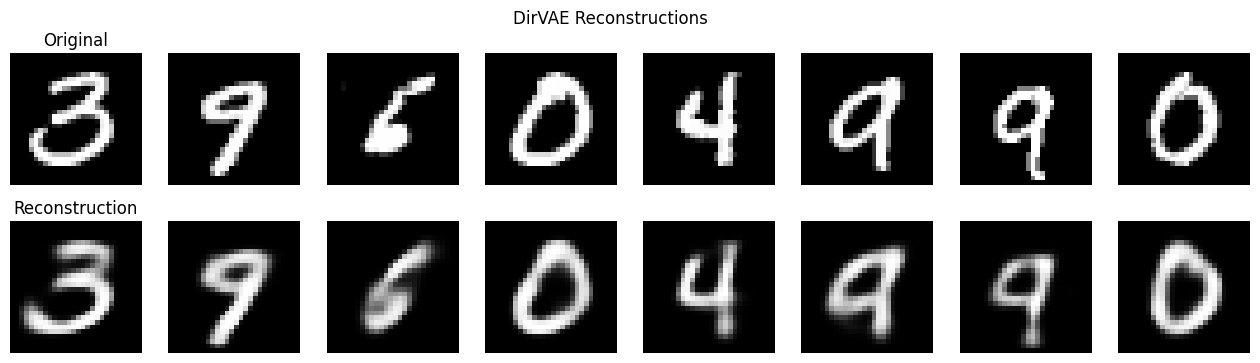

Computing t-SNE projection of DirVAE latent space...


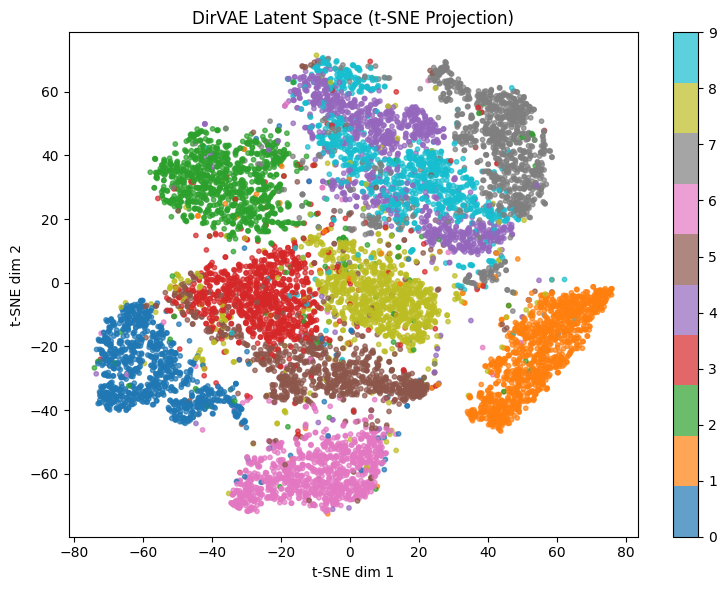

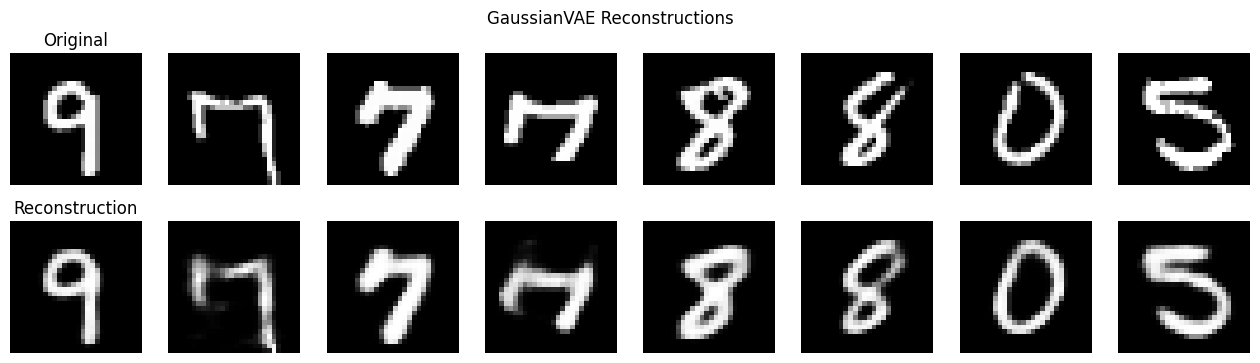

Computing t-SNE projection of GaussianVAE latent space...


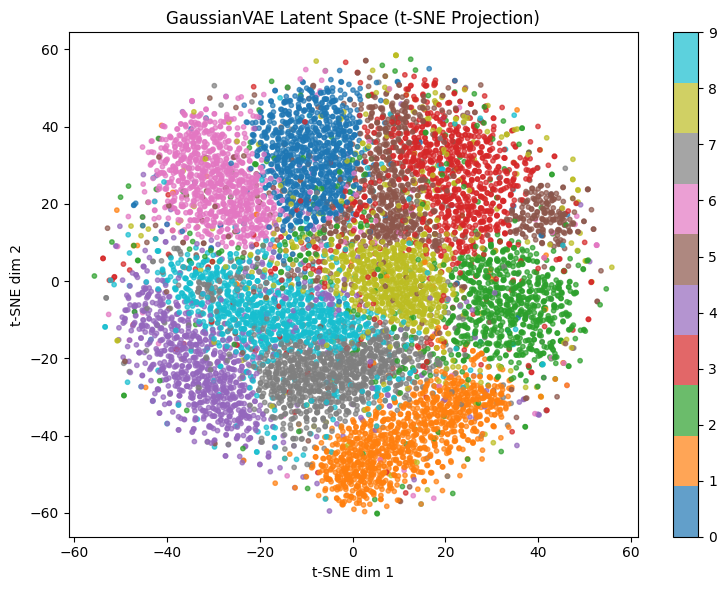

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

def visualize_model(model, loader, device, model_name="Model", n_samples=8, tsne_samples=10000):
    model.eval()

    # -----------------------------
    # Plot some reconstructions
    # -----------------------------
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    with torch.no_grad():
        if isinstance(model, DirVAE):
            logits, z, _, _ = model(xb)
        else:  # GaussianVAE
            logits, mu, logvar, z = model(xb)
        recon = torch.sigmoid(logits)

    xb_np = xb.cpu().numpy()
    recon_np = recon.cpu().numpy()

    plt.figure(figsize=(2*n_samples, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(xb_np[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Reconstruction
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(recon_np[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")

    plt.suptitle(f"{model_name} Reconstructions")
    plt.show()

    # -----------------------------
    # Visualize latent space (t-SNE)
    # -----------------------------
    print(f"Computing t-SNE projection of {model_name} latent space...")

    z_all = []
    y_all = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            if isinstance(model, DirVAE):
                _, z, _, _ = model(xb)
            else:  # GaussianVAE
                _, mu, logvar, z = model(xb)
            z_all.append(z.cpu())
            y_all.append(yb)
            if sum(len(a) for a in z_all) >= tsne_samples:
                break

    z_all = torch.cat(z_all, dim=0)[:tsne_samples].numpy()
    y_all = torch.cat(y_all, dim=0)[:tsne_samples].numpy()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_2d = tsne.fit_transform(z_all)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_all, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f"{model_name} Latent Space (t-SNE Projection)")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Usage
# -----------------------------
visualize_model(model_DIR, loader, device, model_name="DirVAE")
visualize_model(model_GAU, loader, device, model_name="GaussianVAE")
